# Data Cleaning - Teams

In [39]:
import pandas as pd
from utils import *
import os

df = pd.read_csv('../data/raw/teams.csv')
init_num_rows = df.shape[0]

print('Number of rows: {}'.format(df.shape[0]))
print('Number of columns: {}'.format(df.shape[1]))

df.head()

Number of rows: 142
Number of columns: 61


,year,lgID,tmID,franchID,confID,divID,rank,playoff,seeded,firstRound,...,GP,homeW,homeL,awayW,awayL,confW,confL,min,attend,arena
0,9,WNBA,ATL,ATL,EA,NaN,7,N,0,NaN,...,34,1,16,3,14,2,18,6825,141379,Philips Arena
1,10,WNBA,ATL,ATL,EA,NaN,2,Y,0,L,...,34,12,5,6,11,10,12,6950,120737,Philips Arena
2,1,WNBA,CHA,CHA,EA,NaN,8,N,0,NaN,...,32,5,11,3,13,5,16,6475,90963,Charlotte Coliseum
3,2,WNBA,CHA,CHA,EA,NaN,4,Y,0,W,...,32,11,5,7,9,15,6,6500,105525,Charlotte Coliseum
4,3,WNBA,CHA,CHA,EA,NaN,2,Y,0,L,...,32,11,5,7,9,12,9,6450,106670,Charlotte Coliseum


## Dealing with Missing Values / Features

<Axes: title={'center': 'Number of null values per column'}>

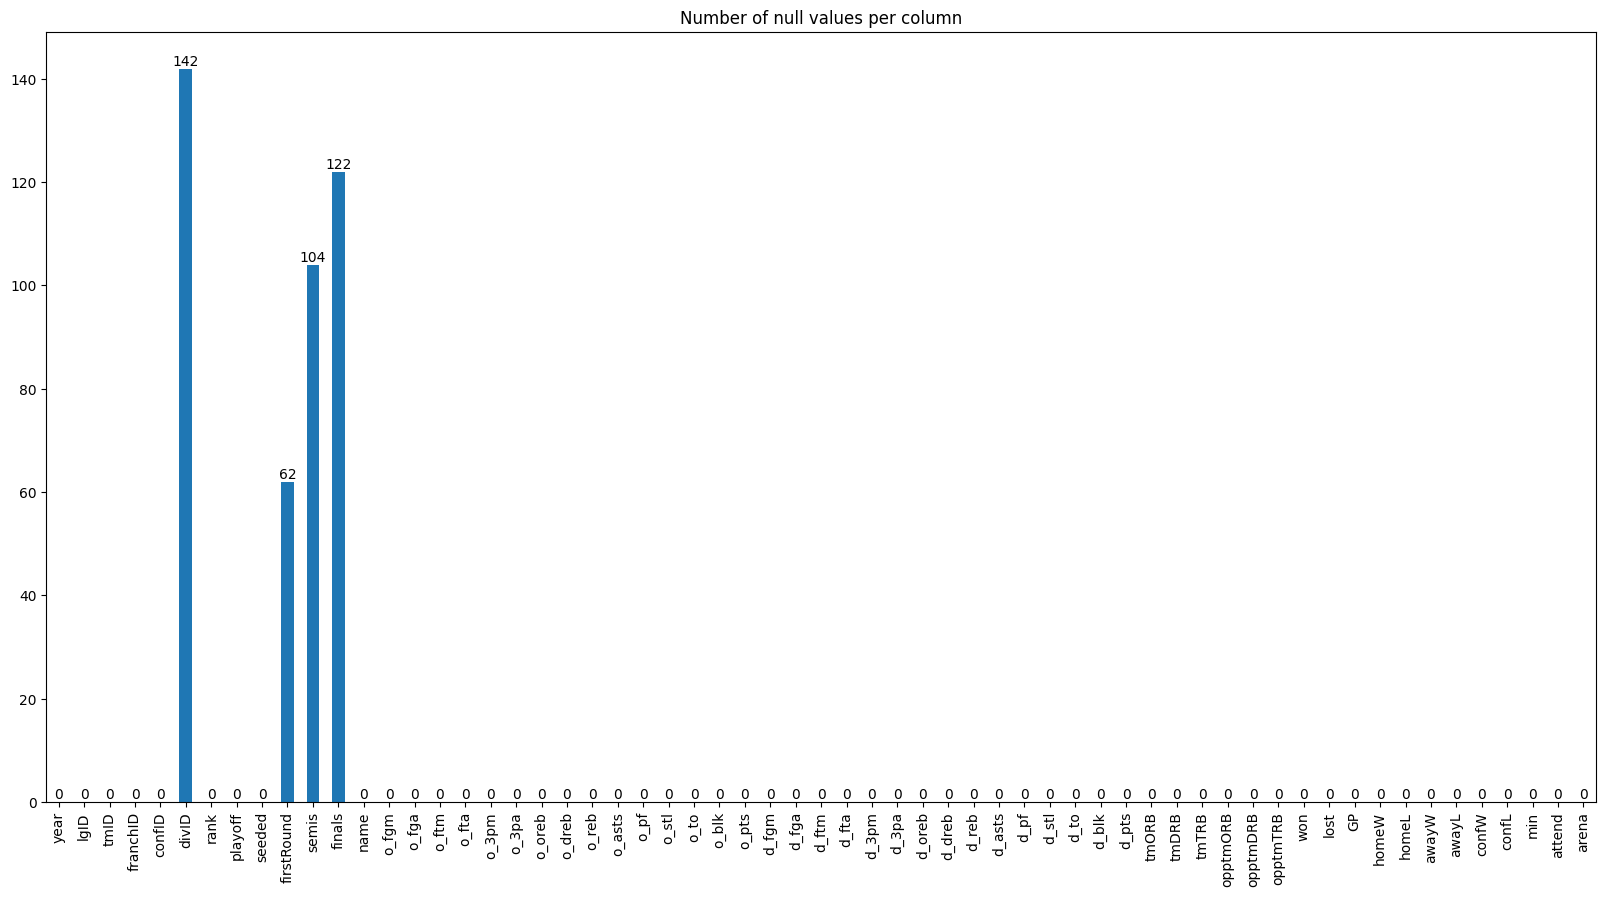

In [40]:
nulls_values_by_column(df, (20, 10))

In [41]:
df.drop(['divID'], inplace=True, axis=1)
df.fillna('N', inplace=True)

## Dealing with Duplicate values / Redundant Data

<Axes: title={'center': 'Number of Unique Values Per Column'}>

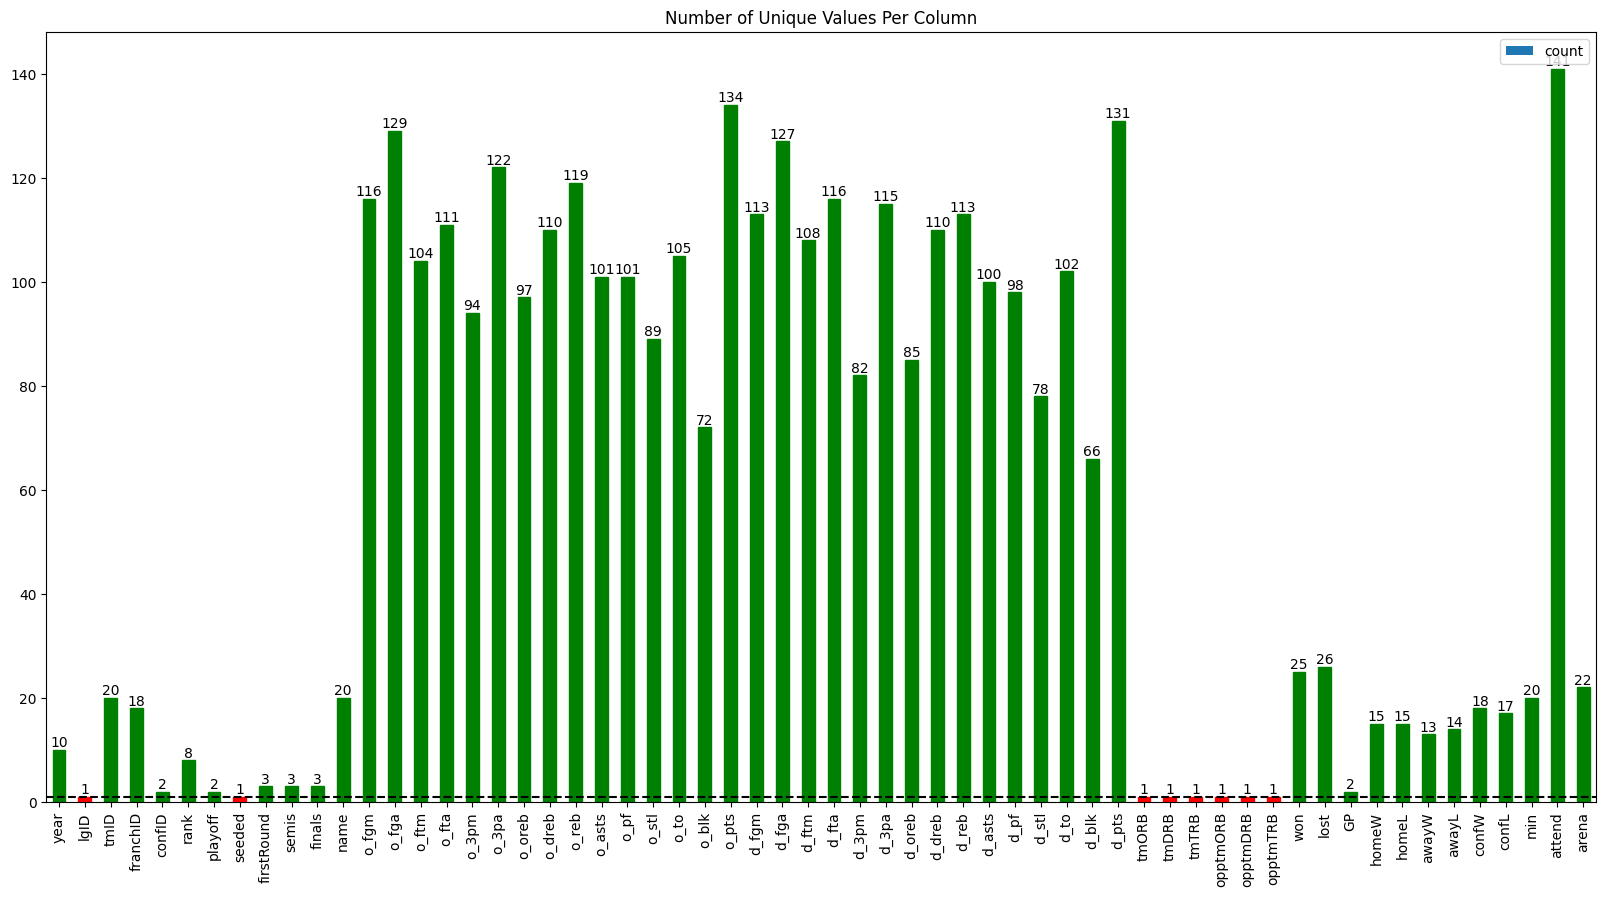

In [42]:
unique_values_by_column(df, 1, (20, 10))

In [43]:
num_columns = len(df.columns)
df = filter_column_uniques(df, 1)
print(f"Removed {num_columns - len(df.columns)} columns that had only one unique value")


Removed 8 columns that had only one unique value


In [44]:
num_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Removed {num_rows - df.shape[0]} repeated rows")

Removed 0 repeated rows


## Outliers and Noise

### Noise

The team discovered that there were two winners in year 6. Consequently, the team decided to rectify the data by accurately identifying the rightful winner.

```json
[
{
    "year": 6,
    "name": "Connecticut Sun"
  },
  {
    "year": 6,
    "name": "Sacramento Monarchs"
  },

]
```



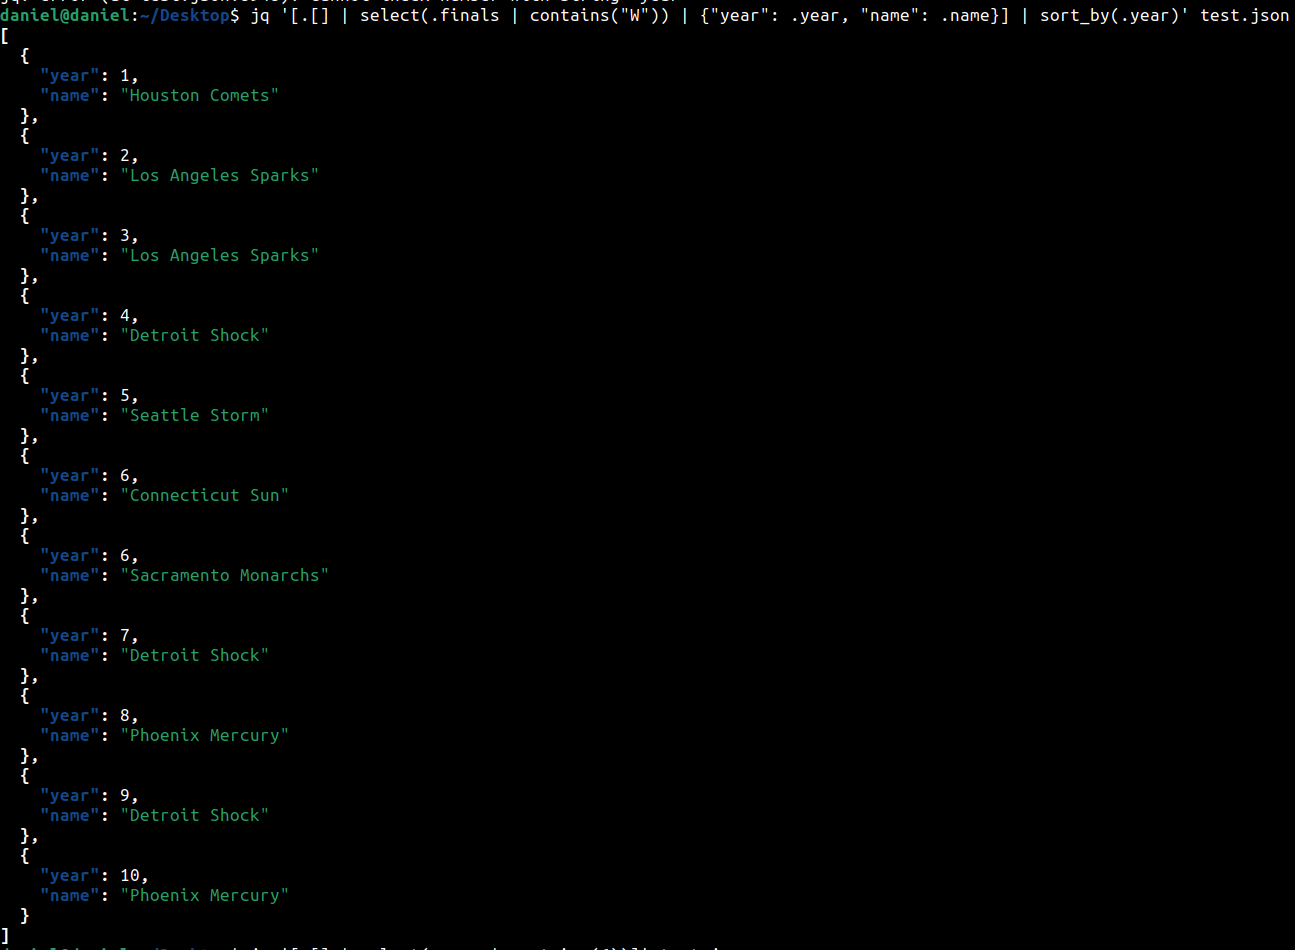

In [45]:
#change the winner to False in year 6 team Connecticut Sun
df.loc[(df['year'] == 6) & (df['name'] == 'Connecticut Sun'), 'finals'] = ''

### ... z-score

This is a simple way to detect outliers using the z-score. The z-score is the number of standard deviations away from the mean a data point is. If the absolute value of the z-score is greater than 3, we can flag this data point as an outlier.

Let's take a look at the z-score range using a histogram plot.

<module 'matplotlib.pyplot' from '/home/daniel/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

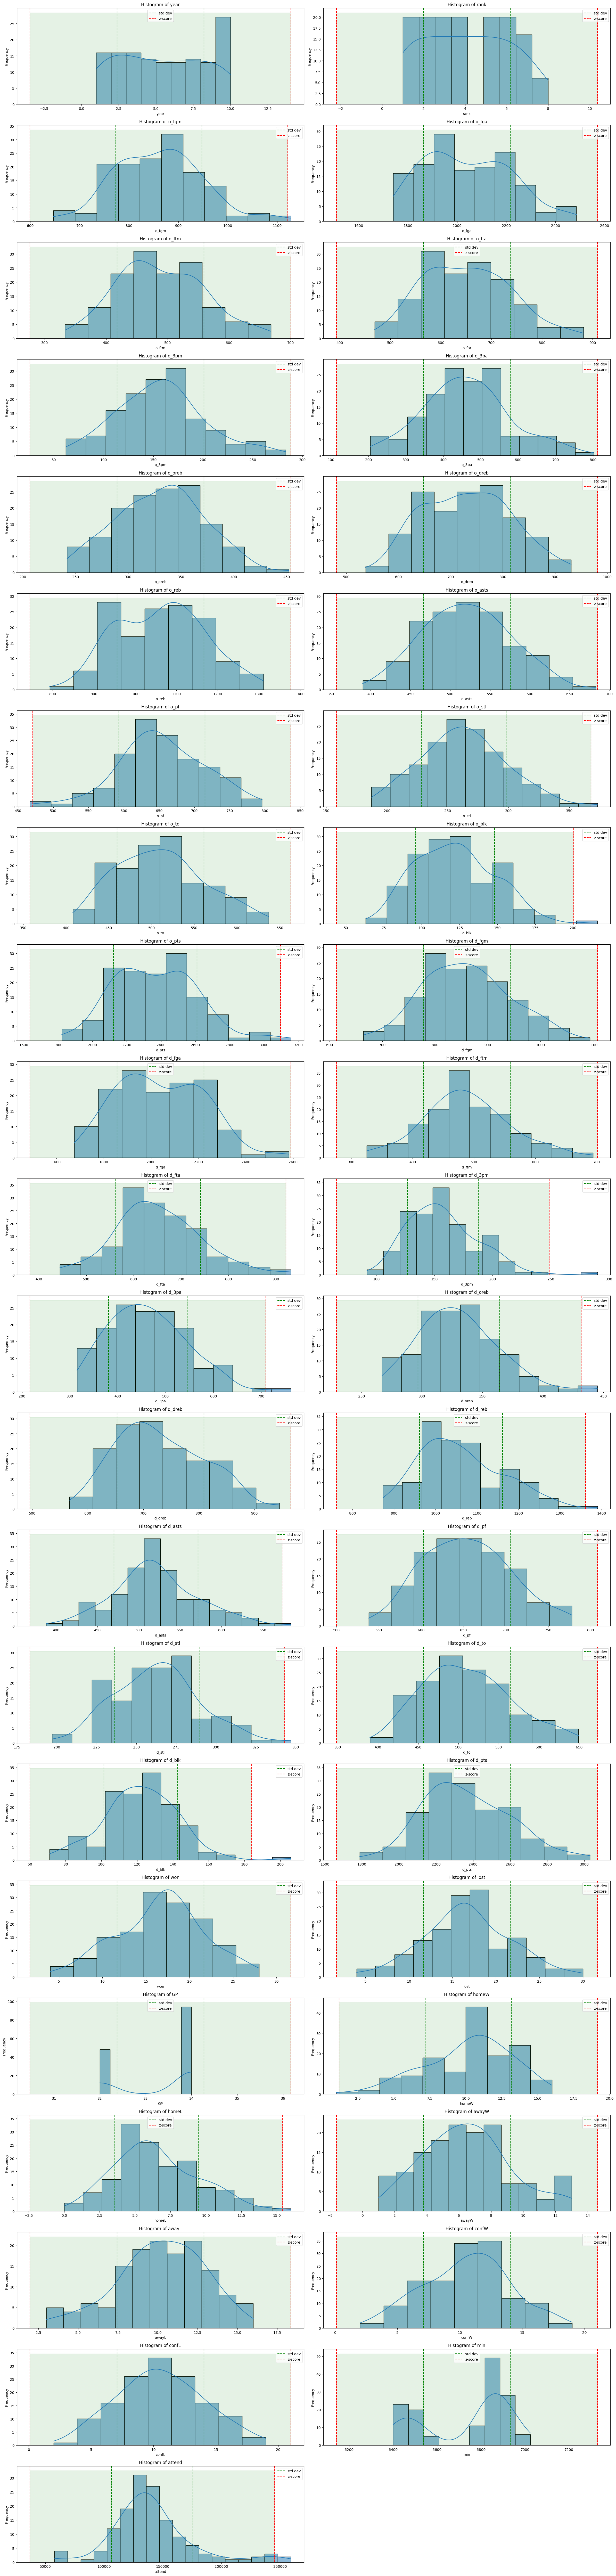

In [47]:
max_zscore = 3
rows2drop = set()
histogram_plot(df, max_zscore, (24, 100))

Now let's use the z-score to detect and remove outliers from the dataset.

In [48]:
rows2drop_zscore = filter_by_zscore(df, max_zscore, ['attend'])
print(f"Removed {len(rows2drop_zscore)} rows with zscore > {max_zscore}")

rows2drop.update(rows2drop_zscore)

Removed 9 rows with zscore > 3


### ... Interquartile Range (IQR)

The interquartile range (IQR) is a measure of statistical dispersion and is calculated as the difference between the 75th and 25th percentiles. It is represented by the formula IQR = Q3 − Q1. The IQR may also be called the midspread or middle 50%. It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.

Let's take a look at the IQR range using a histogram plot.

<module 'matplotlib.pyplot' from '/home/daniel/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

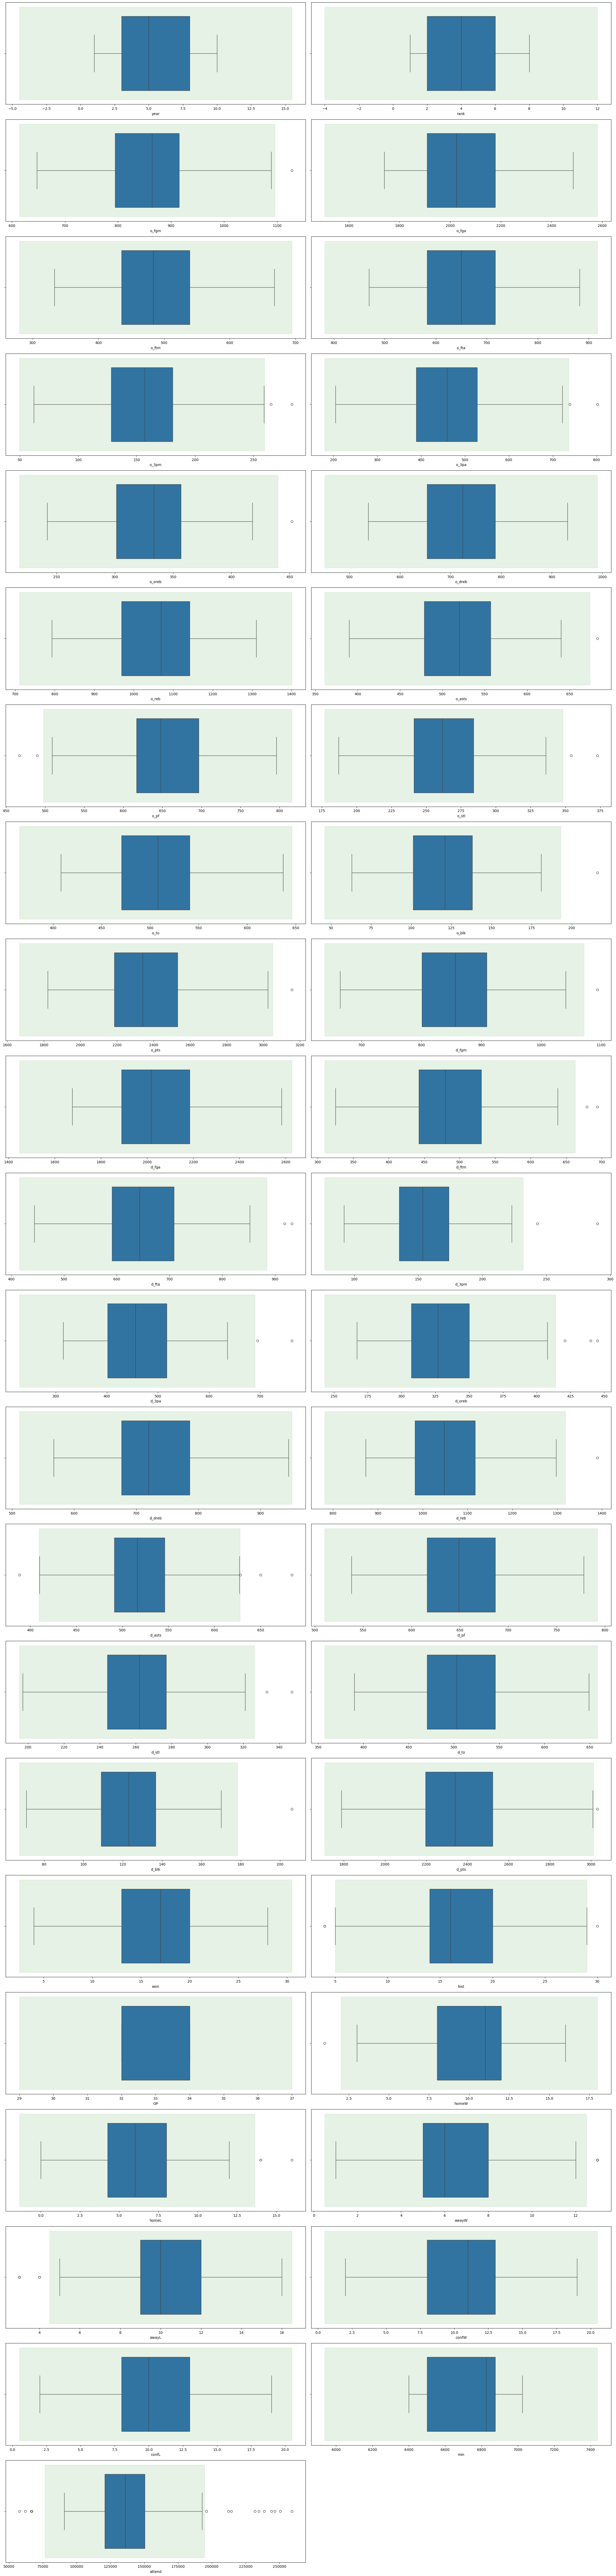

In [49]:
factor = 1.5
iqr_plot(df, factor, (24, 100))

Now let's use the IQR to detect and remove outliers from the dataset.

In [50]:
rows2drop_iqr = filter_by_iqr(df, factor, ['attend'])
print(f"Removed {len(rows2drop_iqr)} rows with factor = {factor}")

rows2drop.update(rows2drop_iqr)

Removed 23 rows with factor = 1.5


In [51]:
print(f"Founded {len(rows2drop)} ({round(len(rows2drop) / df.shape[0] * 100, 1)}%) outliers")
#df.drop(rows2drop, axis = 0, inplace=True)
print(f"Removed {init_num_rows - df.shape[0]} rows ({round((init_num_rows - df.shape[0]) / init_num_rows * 100, 1)}%)")
print(df.columns)


years = sorted(df["year"].unique())

df.sort_values(by=['tmID', 'year'], inplace=True)

print(df)

# Create a new column 'next_year' to store the incremented year
df['next_year'] = df['year'] + 1

# Create a dictionary to map the 'tmID' to the next year's 'playoff' value
df['next_year_playoff'] = df.groupby('tmID')['playoff'].shift(-1).to_dict()
# Use the map to get the 'playoff' value for the next year

df['year'] = df['next_year']
df['playoff'] = df['next_year_playoff']

# Drop the 'next_year' and 'next_year_playoff' columns
df.drop(columns=['next_year', 'next_year_playoff'], inplace=True)
# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)
df = df[(df['year'] <= 10) & (df['year'] >= 2)]
df = df.dropna(subset=["playoff"])



Founded 23 (16.2%) outliers
Removed 0 rows (0.0%)
Index(['year', 'tmID', 'franchID', 'confID', 'rank', 'playoff', 'firstRound',
       'semis', 'finals', 'name', 'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm',
       'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to',
       'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa',
       'd_oreb', 'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk',
       'd_pts', 'won', 'lost', 'GP', 'homeW', 'homeL', 'awayW', 'awayL',
       'confW', 'confL', 'min', 'attend', 'arena'],
      dtype='object')
     year tmID franchID confID  rank playoff firstRound semis finals  \
0       9  ATL      ATL     EA     7       N          N     N      N   
1      10  ATL      ATL     EA     2       Y          L     N      N   
2       1  CHA      CHA     EA     8       N          N     N      N   
3       2  CHA      CHA     EA     4       Y          W     W      L   
4       3  CHA      CHA     EA     2       Y   

In [52]:
print(df['tmID'])

0      ATL
2      CHA
3      CHA
4      CHA
5      CHA
      ... 
136    WAS
137    WAS
138    WAS
139    WAS
140    WAS
Name: tmID, Length: 122, dtype: object


In [53]:
print(sorted(df["year"].unique()))

[2, 3, 4, 5, 6, 7, 8, 9, 10]


## Save Dataset

In [54]:
if not os.path.exists('../data/clean'):
    os.makedirs('../data/clean')

df.to_csv('../data/clean/teams.csv', index=False)